# Explore how find_elms.py works

To construct the time-to-elm target, I'm working through Ge's code:

projects/FRNN/gdong-temp/2021-LM-tune/n1rms-2021-02-08-23-43/7/find_elms.py

I have no idea what it does, but Ge says it detects ELMs. Let's see


In [19]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import patches 
import os

import h5py

First I have to load a dataset. These are there once I call `instantiate.sh`.

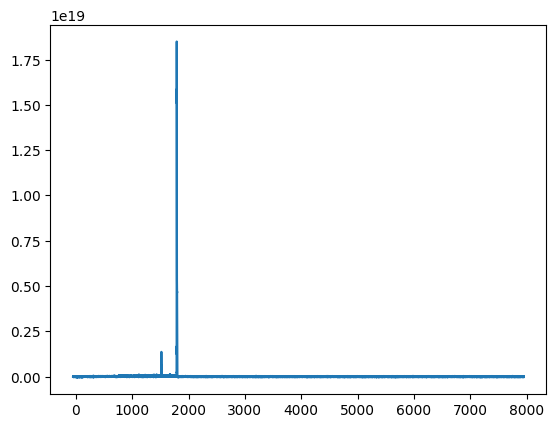

In [8]:
root = "/projects/FRNN/dataset_ELM_full"
shotnr = 187095


with h5py.File(os.path.join(root, "dataset", f"{shotnr}.h5"), 'r') as fp:
    fs07 = fp["/fs07/zdata"][:]
    tb = fp["/fs07/xdata"][:]

plt.plot(tb, fs07)

Next, I copy&paste Ge's function to identify ELMs:

In [9]:
def find_elm_events_tar(time,y,threshold=None,scheme=None,maxi =500):
   res=[]
   assert(len(time)==len(y))
   if len(time)==0:
      return []
   tar = np.ones(len(time))*500
   if threshold==None:
      if scheme==None:
         #print(np.mean(y))
         threshold=np.mean(y)*3
#   print(threshold)
   previous_end = -100
   during_elm = False
   current_elm={}
   for i,yi in enumerate(y):
       if yi>threshold:
          if during_elm == False:
             if time[i]-previous_end>5 or len(res)==0:
                current_elm['begin']=time[i]
                current_elm['begin_index']=i
                current_elm['max']=yi
                during_elm=True
                #print('detected ELM at',time[i],'ms')
             else:
               # print('Combining two ELM crashes......')
                current_elm=res.pop()
                during_elm=True
                current_elm['max']=yi
    
          else:
             current_elm['max'] = max(yi,current_elm['max'])
       else:
          if during_elm == True:
             during_elm = False
             current_elm['end']=time[i]
             current_elm['end_index']=i
             res.append(current_elm)
             current_elm={}
             previous_end=time[i]
             #print('ELM ended at',time[i],'ms')
             #print('******************************************')

    
   if during_elm == True:
             during_elm = False
             current_elm['end']=time[i]
             current_elm['end_index']=i
             res.append(current_elm)
             current_elm={}
             previous_end=time[i]
   
   #print(len(res),'ELM events detected~~~!!!')
   previous_end =0
   for e in res:
       index_begin = e['begin_index']
       index_end = e['end_index']
       tar[previous_end:index_begin] = time[index_begin]-time[previous_end:index_begin]
       tar[index_begin:index_end] = 0 #during ELM
       previous_end = index_end

   #print(tar.shape)
   return res,tar
                

In [15]:
# Now call the function and look at the results

res, tar = find_elm_events_tar(tb, fs07)
print(type(res), type(tar))

<class 'list'> <class 'numpy.ndarray'>


In [16]:
# res is a list of dicts. Each with keys 'begin', 'begin_index', 'max', end', 'end_index'
print(res[:10])

[{'begin': 312.53998, 'begin_index': 18126, 'max': 5.615935e+16, 'end': 312.55997, 'end_index': 18127}, {'begin': 760.38, 'begin_index': 40518, 'max': 5.2090867e+16, 'end': 761.0, 'end_index': 40549}, {'begin': 773.94, 'begin_index': 41196, 'max': 7.6501786e+16, 'end': 774.2, 'end_index': 41209}, {'begin': 783.18, 'begin_index': 41658, 'max': 5.615935e+16, 'end': 783.2, 'end_index': 41659}, {'begin': 799.32, 'begin_index': 42465, 'max': 5.615935e+16, 'end': 799.58, 'end_index': 42478}, {'begin': 808.1, 'begin_index': 42904, 'max': 5.2090867e+16, 'end': 809.1, 'end_index': 42954}, {'begin': 820.12, 'begin_index': 43505, 'max': 5.2090867e+16, 'end': 820.14, 'end_index': 43506}, {'begin': 831.62, 'begin_index': 44080, 'max': 7.6501786e+16, 'end': 831.64, 'end_index': 44081}, {'begin': 855.5, 'begin_index': 45274, 'max': 5.2090867e+16, 'end': 855.96, 'end_index': 45297}, {'begin': 865.88, 'begin_index': 45793, 'max': 5.2090867e+16, 'end': 865.9, 'end_index': 45794}]


res is a list of dicts that describe individual ELM events. Let's visualize some ELMs

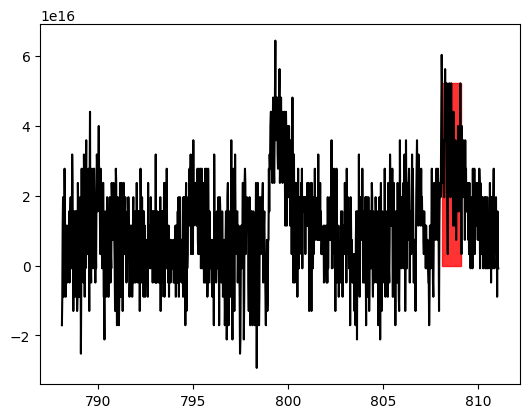

In [34]:
# Indices where to plot
elm = res[5]
ix_p0 = elm["begin_index"] - 1000
ix_p1 = elm["end_index"] + 100

fig = plt.figure()
ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])

ax.plot(tb[ix_p0:ix_p1], fs07[ix_p0:ix_p1], 'k')

p = patches.Rectangle((elm['begin'], 0.0), elm['end'] - elm['begin'], elm['max'], color="red", alpha=0.8)
ax.add_patch(p)


The result of `find_elms_event_tar` is a list of dictionaries. Each dictionary describes an ELM with it's starting position.

Let's continue with tar

(0.0, 50.0)

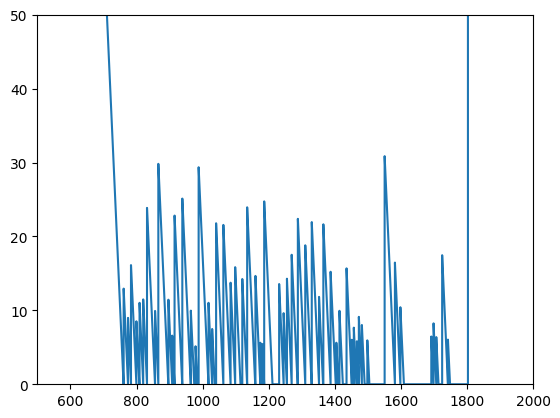

In [38]:
plt.plot(tb, tar)
plt.xlim(500.0, 2000.0)
plt.ylim((0.0, 50.0))

It looks like tar just gives the time-to-elm. This is the value to calculate the TTELM target with.